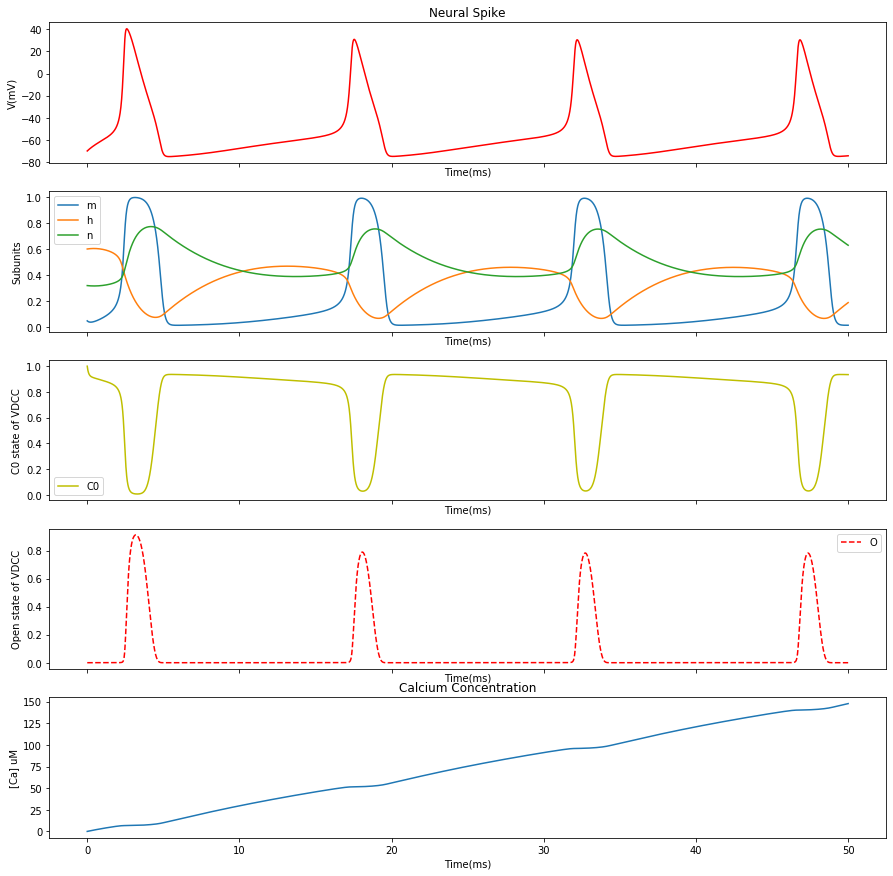

In [11]:
'''The following model of Voltage Dependent Calcium Channel (VDCC) has been adapted from Bischofbereger et., al 2010. This model consists of 5 state of which 4 are in 
closed state represented by C0, C1, C2 & C3 and 1 is in open state represented as O'''

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

#Defining HH model kinetics
Cm = 1.0   #uF/cm^2
gK = 36.0  #mS/cm^2
gNa = 120.0 #mS/cm^2
gl = 0.3  #mS/cm^2
VK = -77.0  #mV
VNa = 50.0  #mV
Vl = -54.4  #mV
z = 2    #Charge of Calcium ion
F = 96480  #Faraday constant (C/mol)
Vol = 1  #um^3

# Function that will store variables associated with sodium channel
def Sodium_values(V):
    
    alpha_m = (0.1*(V + 40.0))/(1.0 - np.exp(-(V + 40.0)/10.0))
    beta_m = 4.0*np.exp(-(V + 65.0)/18.0)
    alpha_h = 0.07 * np.exp(-(V + 65.0)/20.0)
    beta_h = 1.0/(1.0 + np.exp(-(V + 35.0)/10.0))
    m_initial = alpha_m/(alpha_m + beta_m)
    h_initial = alpha_h/(alpha_h + beta_h)
    
    return [alpha_m,beta_m,alpha_h,beta_h,m_initial,h_initial]

# Function that will store variables associated with Pottasium channel
def Potassium_values(V):
    
    alpha_n = (0.01*(V + 55.0))/(1 - np.exp(-(V + 55.0)/10.0))
    beta_n = 0.125 * np.exp(-(V + 65.0)/80.0)
    n_initial = alpha_n/(alpha_n + beta_n)
    
    return [alpha_n,beta_n,n_initial]

# Function that will store variables associated with Calcium channel
def Calcium_values(V):
    
    alpha_1 = 4.04*np.exp(V/49.14)
    alpha_2 = 6.70*np.exp(V/42.08)
    alpha_3 = 4.39*np.exp(V/55.31)
    alpha_4 = 17.33*np.exp(V/26.55)
    beta_1 = 2.88*np.exp(-V/49.14)
    beta_2 = 6.30*np.exp(-V/42.08)
    beta_3 = 8.16*np.exp(-V/55.31)
    beta_4 = 1.84*np.exp(-V/26.55)
    
    return [alpha_1,alpha_2,alpha_3,alpha_4,beta_1,beta_2,beta_3,beta_4]

#Giving an external current
def I_ext(t):
    return 10  #nA

def f(V):
    P = -3.003
    C = 80.36
    D = 0.3933
    I = P*V*((D - np.exp(-V/C))/(1-np.exp(V/C)))*1e03
    return I

# Defining the model that will run the simulation
def model(y,t):
    dy = np.zeros((10,))
    V = y[0]            #Voltage
    m = y[1]            #m subunit
    h = y[2]            #h subunit
    n = y[3]            #n subunit
    C0 = y[4]           #Calcium state C0
    C1 = y[5]           #Calcium state C1
    C2 = y[6]           #Calcium state C2
    C3 = y[7]           #Calcium state C3
    O = y[8]           #Calcium state O
    Ca = y[9]
    
    [alpha_n,beta_n,n_initial] = Potassium_values(V)
    [alpha_m,beta_m,alpha_h,beta_h,m_initial,h_intial] = Sodium_values(V)
    [alpha_1,alpha_2,alpha_3,alpha_4,beta_1,beta_2,beta_3,beta_4] = Calcium_values(V)
    I = f(V)
    
    dy[0] = (I_ext(t)/Cm) - ((gK*np.power(n,4)*(V-VK))/(Cm)) - ((gNa*np.power(m,3)*h*(V-VNa))/(Cm)) - ((gl*(V-Vl))/Cm) 
    dy[1] = (alpha_m*(1-m)) - (beta_m*m)
    dy[2] = (alpha_h*(1-h)) - (beta_h*h)
    dy[3] = (alpha_n*(1-n)) - (beta_n*n)
    dy[4] = (beta_1*C1) - (alpha_1*C0)
    dy[5] = (alpha_1*C0 + beta_2*C2) - ((alpha_2 + beta_1)*C1) 
    dy[6] = (alpha_2*C1 + beta_3*C3) - ((alpha_3 + beta_2)*C2) 
    dy[7] = (alpha_3*C2 + beta_4*O) - ((alpha_4 + beta_3)*C3)
    dy[8] = (alpha_4*C3) - (beta_4*O)
    dy[9] = (-I)/(z*F*Vol)
    return dy

#initialising parameters
y0 = [-70,0.05,0.6,0.32,1,0,0,0,0,100e-09]

#time range
t = np.arange(0.0,50.01,0.01)

#solving the set of ODEs
sol = odeint(model,y0,t)


#Plotting the output
fig, ax = plt.subplots(5, figsize=(15,15), sharex=True)
ax[0].plot(t,sol[:,0],'r',label="V")
ax[0].set_xlabel("Time(ms)")
ax[0].set_ylabel("V(mV)")
ax[0].set_title("Neural Spike")

ax[1].plot(t,sol[:,1],label="m")
ax[1].plot(t,sol[:,2],label="h")
ax[1].plot(t,sol[:,3],label="n")
ax[1].set_xlabel("Time(ms)")
ax[1].set_ylabel("Subunits")
ax[1].legend()

ax[2].plot(t,sol[:,4],'y',label="C0")
ax[2].set_xlabel("Time(ms)")
ax[2].set_ylabel("C0 state of VDCC")
ax[2].legend()

ax[3].plot(t,sol[:,8],'r--',label="O")
ax[3].set_xlabel("Time(ms)")
ax[3].set_ylabel("Open state of VDCC")
ax[3].legend()

ax[4].plot(t,sol[:,9])
ax[4].set_xlabel("Time(ms)")
ax[4].set_ylabel("[Ca] uM")
ax[4].set_title("Calcium Concentration")
plt.show()